# Análisis y Modelado de Series de Tiempo de Combustibles en Guatemala: Consumo, Importación y Precios (2000–2025)

## Carga, limpieza y preparación de datos

1. Unificación de archivos
2. Selección de variables objetivo
3. Operaciones para unificar columnas
4. Estandarización de formatos (datetime y unidad en precios GQTZ/GAL)
5. Implementación de *caché* para leer los archivos de salida una vez que ya esten generados los posea el usuario


En caso de querer hacer el procedimiento de limpieza y unificación de datos se puede borrar el archivo `cache/df_cache.txt` este controla el proceso para hacer la unificación del proceso o leer unicamente los csv generados; si se desea usar los csv que ya se tienen estos siempre leeran los archivos de **data-ouput** y tranformando la columna "Fecha" a `DateTime` por lo que no es necesario validar, adicional el encabezado manejado, variables, control se encuentra en la sección de **Variables - Constantes**.

### Librerias

In [ ]:
import pandas as pd
import numpy as np
import os

### Variables - Constantes

In [ ]:
DATA_DIR = "./data-input"
OUTPUT_DIR = "./data-output"
REPORTES = "./reportes"
CACHE = "./cache"

# input files
CONSUMO_2024_XLSX = f"{DATA_DIR}/CONSUMO-HIDROCARBUROS-2024-12.xlsx"
CONSUMO_2025_XLSX = f"{DATA_DIR}/VENTAS-HIDROCARBUROS-2025-05.xlsx"
IMPORT_2024_XLSX = f"{DATA_DIR}/IMPORTACION-HIDROCARBUROS-VOLUMEN-2024-12.xlsx"
IMPORT_2025_XLSX = f"{DATA_DIR}/IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx"
PRECIOS_2025_XLSX = f"{DATA_DIR}/Precios-Promedio-Nacionales-Diarios-2025-1.xlsx"

# output files
CONSUMO_CSV = f"{OUTPUT_DIR}/consumo_combustibles.csv"
IMPORT_CSV = f"{OUTPUT_DIR}/importacion_combustibles.csv"
PRECIOS_CSV = f"{OUTPUT_DIR}/precios_diarios.csv"
TARGET_COLUMNS = ["fecha", "regular", "superior", "diesel", "glp"]

# var control
SAVE_CONSUMO_CSV = True
SAVE_IMPORT_CSV = True
SAVE_PRECIOS_CSV = True
SAVE_REPORTES = True

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(REPORTES, exist_ok=True)
os.makedirs(CACHE, exist_ok=True)

### Carga y conversión de archivos Excel a CSV

In [ ]:
def loadAndProcessFuelData(file2024, file2025, saveCsv=False, outputCsvPath=None):
    # Load 2024 data
    df2024 = pd.read_excel(file2024, skiprows=6)
    df2024.columns = df2024.columns.str.strip().str.lower()
    print(f"2024 Data: {df2024.shape[0]} rows, {df2024.shape[1]} columns")

    # Drop last 3 rows
    df2024 = df2024.iloc[:-3]
    print("Removed unnecessary rows from 2024 data.")
    print(f"Updated 2024 Data: {df2024.shape[0]} rows, {df2024.shape[1]} columns")

    # Select and process columns
    target_col_2024 = [
        "fecha",
        "gas licuado de petróleo",
        "gasolina regular",
        "gasolina superior",
        "diesel alto azufre",
        "diesel bajo azufre"
    ]
    df2024 = df2024[target_col_2024]
    df2024["diesel bajo azufre"] = df2024["diesel bajo azufre"] + df2024["diesel alto azufre"]
    df2024 = df2024.drop(columns=["diesel alto azufre"])
    print("Processed 2024 columns.")

    # Load 2025 data
    df2025 = pd.read_excel(file2025, skiprows=6)
    df2025.columns = df2025.columns.str.strip().str.lower()
    print(f"2025 Data: {df2025.shape[0]} rows, {df2025.shape[1]} columns")

    # Drop last 3 rows
    df2025 = df2025.iloc[:-3]
    print("Removed unnecessary rows from 2025 data.")
    print(f"Updated 2025 Data: {df2025.shape[0]} rows, {df2025.shape[1]} columns")

    # Select target columns
    target_col_2025 = [
        "fecha",
        "gas licuado de petróleo",
        "gasolina regular",
        "gasolina superior",
        "diesel bajo azufre"
    ]
    df2025 = df2025[target_col_2025]
    print("Processed 2025 columns.")

    # Concatenate both years
    dfResult = pd.concat([df2024, df2025], ignore_index=True)
    print("Merged 2024 and 2025 data.")
    
    # Convert 'fecha' to datetime
    dfResult["fecha"] = pd.to_datetime(dfResult["fecha"])
    print("Converted 'fecha' column to datetime.")

    # Rename and reorder columns
    dfResult.rename(columns={
        "fecha": "fecha",
        "gasolina regular": "regular",
        "gasolina superior": "superior",
        "diesel bajo azufre": "diesel",
        "gas licuado de petróleo": "glp"
    }, inplace=True)

    dfResult = dfResult[TARGET_COLUMNS]

    # Save to CSV if requested
    if saveCsv and outputCsvPath:
        dfResult.to_csv(outputCsvPath, index=False)
        print(f"Data saved to {outputCsvPath}")

    return dfResult

In [ ]:
def loadAndProcessMultipleSheets(configList, saveCsv=False, outputCsvPath=None):
    dfs = []

    for config in configList:
        filePath = config["filePath"]
        sheetName = config["sheetName"]
        skipRows = config["skipRows"]
        rowsToRemove = config["rowsToRemove"]

        # Leer hoja
        df = pd.read_excel(filePath, header=[0, 1], skiprows=skipRows, sheet_name=sheetName)
        print(f"Loaded sheet '{sheetName}': {df.shape[0]} rows")

        # Eliminar filas finales
        df = df.iloc[:-rowsToRemove]

        # Seleccionar columnas objetivo
        target_columns_multi = [
            ('FECHA', 'Unnamed: 0_level_1'),
            ('Regular', 'GTQ/GALON'),
            ('Superior', 'GTQ/GALON'),
            ('Diesel', 'GTQ/GALON'),
            ('Glp Cilindro 25Lbs.', 'GTQ/LB')
        ]
        df = df[target_columns_multi]

        # Aplanar nombres
        df.columns = [f"{col1.strip()}".lower() for col1, col2 in df.columns]

        # GLP conversión de GTQ/lb a GTQ/galón (25 lbs * 4.24)
        if 'glp cilindro 25lbs.' in df.columns:
            df['glp'] = df['glp cilindro 25lbs.'] * 4.24
            df.drop(columns=['glp cilindro 25lbs.'], inplace=True)
        else:
            df['glp'] = np.nan

        # Reordenar columnas finales
        df = df[TARGET_COLUMNS]

        print(f"Processed sheet '{sheetName}' with {df.shape[0]} rows")
        dfs.append(df)

    # Concatenar todo
    df_final = pd.concat(dfs, ignore_index=True)

    # Convertir fecha
    df_final["fecha"] = pd.to_datetime(df_final["fecha"])
    print("Converted 'fecha' column to datetime.")

    # Guardar si aplica
    if saveCsv and outputCsvPath:
        df_final.to_csv(outputCsvPath, index=False)
        print(f"Final data saved to {outputCsvPath}")

    return df_final

In [ ]:
def loadAllData():
    CACHE_FLAG = os.path.join(CACHE, "df_cache.txt")
    if not os.path.exists(CACHE_FLAG):
        configList = [
            {"filePath": PRECIOS_2025_XLSX, "sheetName": 0, "skipRows": 7, "rowsToRemove": 9},
            {"filePath": PRECIOS_2025_XLSX, "sheetName": 1, "skipRows": 7, "rowsToRemove": 2},
            {"filePath": PRECIOS_2025_XLSX, "sheetName": 2, "skipRows": 7, "rowsToRemove": 2},
            {"filePath": PRECIOS_2025_XLSX, "sheetName": 3, "skipRows": 6, "rowsToRemove": 2},
            {"filePath": PRECIOS_2025_XLSX, "sheetName": 4, "skipRows": 6, "rowsToRemove": 2}
        ]

        df_consumo = loadAndProcessFuelData(CONSUMO_2024_XLSX, CONSUMO_2025_XLSX, saveCsv=SAVE_CONSUMO_CSV, outputCsvPath=CONSUMO_CSV)
        df_importaciones = loadAndProcessFuelData(IMPORT_2024_XLSX, IMPORT_2025_XLSX, saveCsv=SAVE_IMPORT_CSV, outputCsvPath=IMPORT_CSV)

        df_precios = loadAndProcessMultipleSheets(
            configList=configList,
            saveCsv=SAVE_PRECIOS_CSV,
            outputCsvPath=PRECIOS_CSV
        )
        
        with open(CACHE_FLAG, "w") as f:
            f.write("cached")

        print("Procesamiento completado desde archivos fuente.")
    else:
        df_consumo = pd.read_csv(CONSUMO_CSV, parse_dates=["fecha"])
        df_importaciones = pd.read_csv(IMPORT_CSV, parse_dates=["fecha"])
        df_precios = pd.read_csv(PRECIOS_CSV, parse_dates=["fecha"])

        print("Datos cargados desde cache CSV.")
    return df_consumo, df_importaciones, df_precios

### Generación de reportes para explorar data

In [ ]:
def generateBasicReport(df, name):
    report_path = os.path.join(REPORTES, f"{name}_reporte.txt")

    with open(report_path, "w", encoding="utf-8") as f:
        f.write("REPORTE BÁSICO DE DATAFRAME\n")
        f.write("=" * 40 + "\n\n")

        # Dimensiones
        f.write(f"Total filas: {df.shape[0]}\n")
        f.write(f"Total columnas: {df.shape[1]}\n\n")

        # Columnas
        f.write("Columnas:\n")
        for col in df.columns:
            f.write(f"  - {col}\n")
        f.write("\n")

        # Tipos de datos
        f.write("Tipos de datos por columna:\n")
        f.write(df.dtypes.to_string())
        f.write("\n\n")

        # Nulos
        f.write("Valores nulos por columna:\n")
        f.write(df.isnull().sum().to_string())
        f.write("\n\n")

        # Porcentaje de nulos
        f.write("Porcentaje de nulos por columna:\n")
        null_pct = (df.isnull().mean() * 100).round(2)
        f.write(null_pct.to_string())
        f.write("\n\n")

        # Duplicados
        f.write(f"Total filas duplicadas: {df.duplicated().sum()}\n\n")

        # Estadísticas básicas (numéricas)
        f.write("Estadísticas básicas (solo numéricas):\n")
        f.write(df.describe().to_string())
        f.write("\n\n")

        # Medianas
        f.write("Mediana por columna numérica:\n")
        f.write(df.median(numeric_only=True).to_string())
        f.write("\n")

    print(f"Reporte generado en: {report_path}")


In [ ]:
if SAVE_REPORTES:
  df_consumo, df_importaciones, df_precios = loadAllData()
  generateBasicReport(df_consumo, "consumo_combustibles")
  generateBasicReport(df_importaciones, "importacion_combustibles")
  generateBasicReport(df_precios, "precios_combustibles")

## Análisis exploratorio

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [ ]:
IMAGES_DIR = "./images"

HISTOGRAMA = os.path.join(IMAGES_DIR, "histogramas")
ST = os.path.join(IMAGES_DIR, "series_tiempo")

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(HISTOGRAMA, exist_ok=True)
os.makedirs(ST, exist_ok=True)

In [ ]:
df_consumo, df_importaciones, df_precios = loadAllData()
df_consumo.set_index('fecha', inplace=True)
df_importaciones.set_index('fecha', inplace=True)
df_precios.set_index('fecha', inplace=True)

### Resumen Estadístico

In [ ]:
print("Resumen consumo:\n", df_consumo.describe())
print("\nResumen importaciones:\n", df_importaciones.describe())
print("\nResumen precios:\n", df_precios.describe())

### Histogramas

In [ ]:
for df, nombre in zip([df_consumo, df_importaciones, df_precios], 
                      ['consumo', 'importaciones', 'precios']):
    axes = df.hist(figsize=(10, 6), bins=30)

    for ax in axes.flatten():
        ax.tick_params(axis='both', labelsize=8)
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(3, 5))
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(3, 5))
        ax.set_title(ax.get_title(), fontsize=9)
        ax.set_xlabel("Valor", fontsize=9)
        ax.set_ylabel("Frecuencia", fontsize=9)

    plt.suptitle(f'Distribución de variables - {nombre.capitalize()}', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    path_salida = os.path.join(HISTOGRAMA, f"{nombre}_histograma.png")
    plt.savefig(path_salida, dpi=150)
    plt.show()

### Series de tiempo

In [178]:
def graphST(df, titulo, nombre_archivo_base):
    subdir = os.path.join(ST, nombre_archivo_base)
    os.makedirs(subdir, exist_ok=True)

    # Gráfica combinada
    df.plot(figsize=(12, 6))
    plt.title(f"Series de tiempo - {titulo}", fontsize=12)
    plt.xlabel("Fecha", fontsize=10)
    plt.ylabel("Valor", fontsize=10)
    plt.grid(True)
    plt.tight_layout()

    # Guardar imagen combinada
    path = os.path.join(subdir, f"{nombre_archivo_base}_combinada.png")
    plt.savefig(path, dpi=150)
    plt.show()

    # Gráficas individuales por columna
    for col in df.columns:
        plt.figure(figsize=(10, 5))
        df[col].plot()
        plt.title(f"{titulo} - {col.capitalize()}", fontsize=11)
        plt.xlabel("Fecha", fontsize=9)
        plt.ylabel("Valor", fontsize=9)
        plt.grid(True)
        plt.tight_layout()

        # Guardar cada gráfica individual
        col_sanitized = col.lower().replace(" ", "_")
        path_indiv = os.path.join(subdir, f"{nombre_archivo_base}_{col_sanitized}.png")
        plt.savefig(path_indiv, dpi=150)
        plt.show()

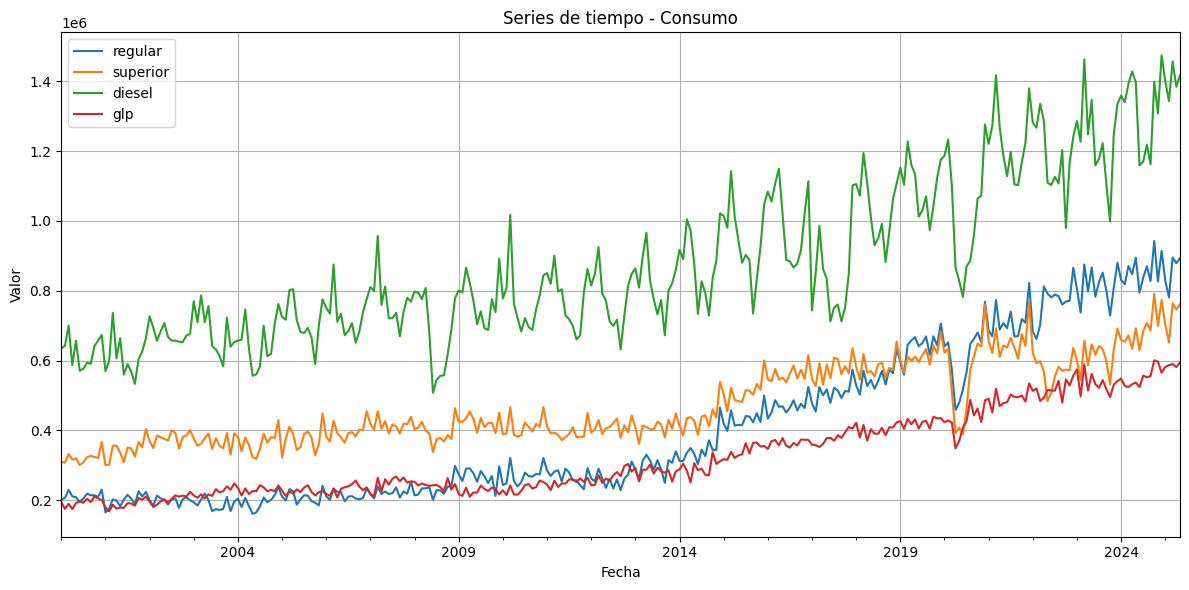

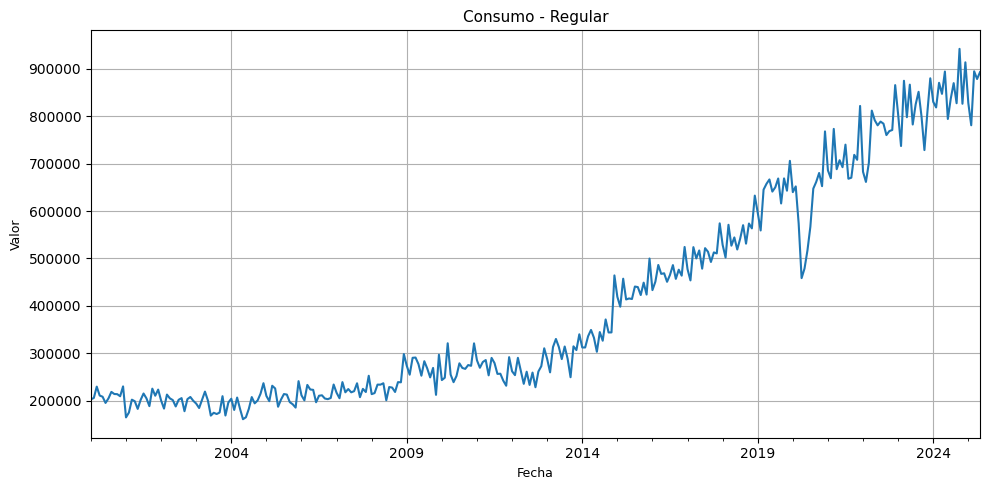

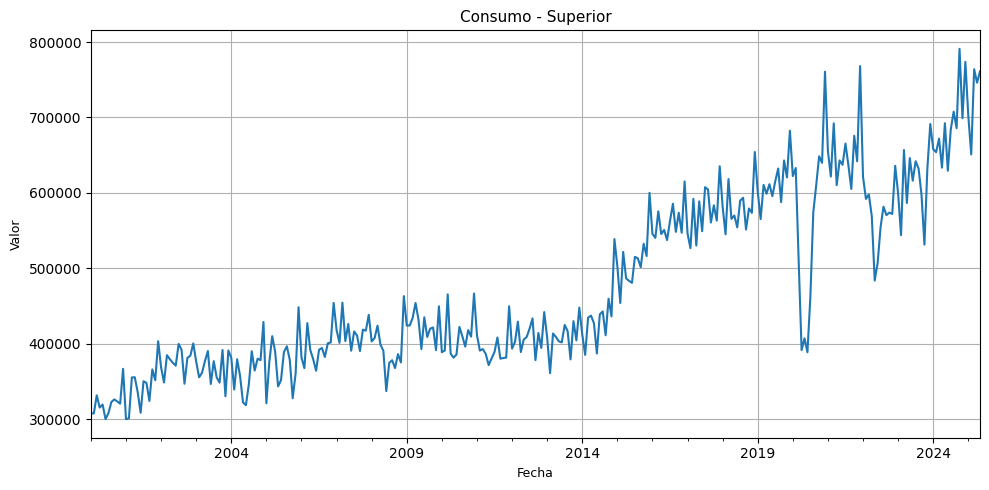

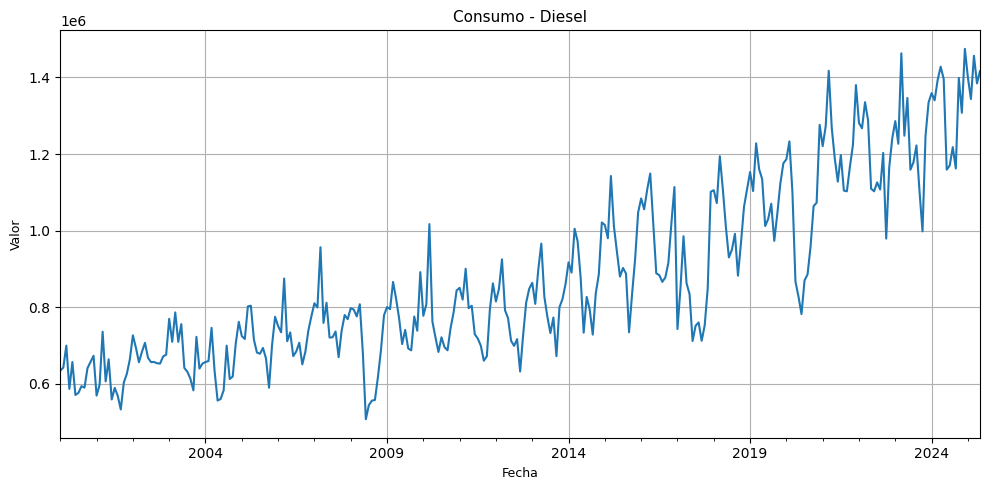

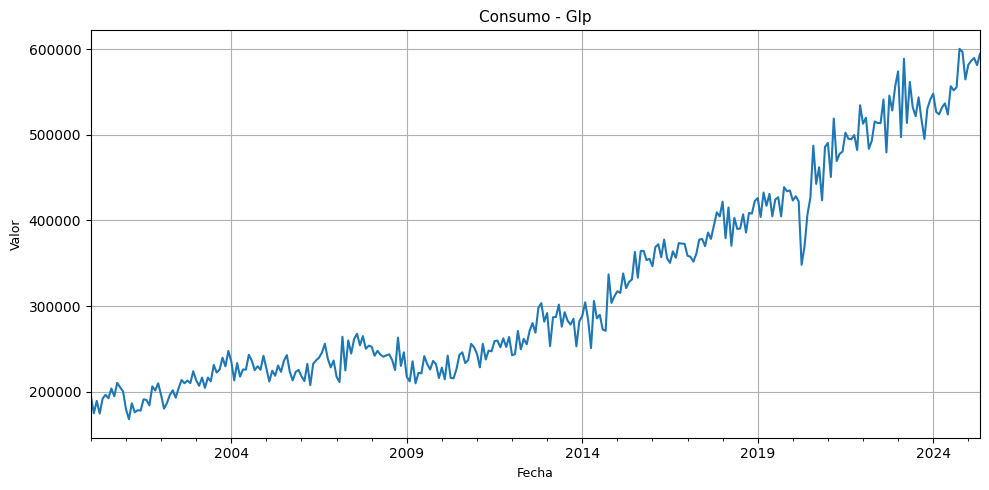

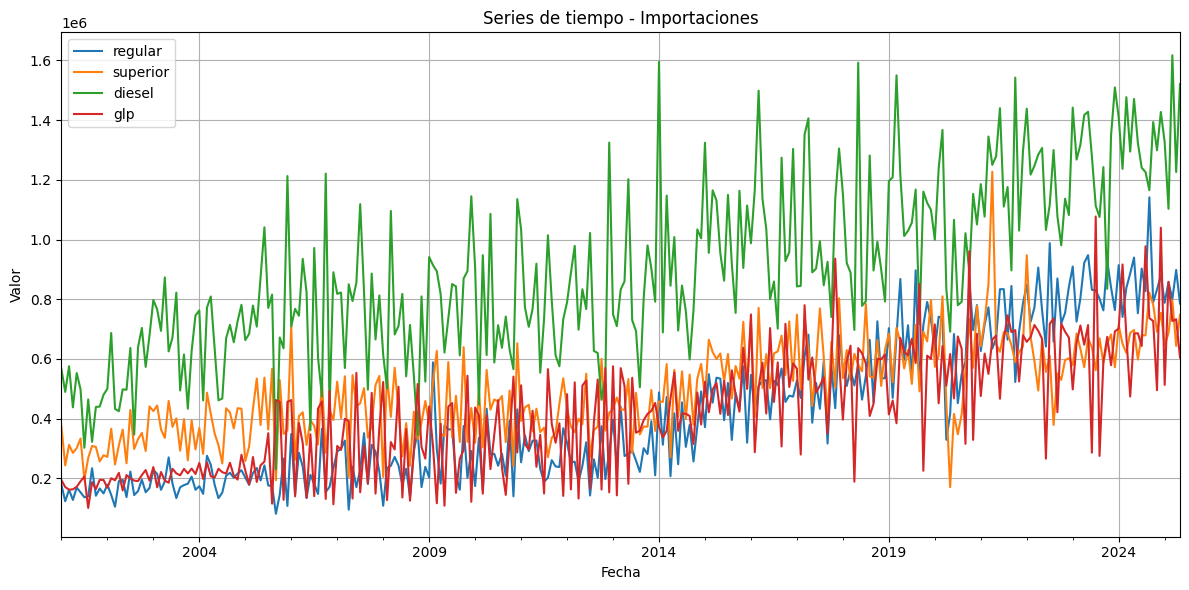

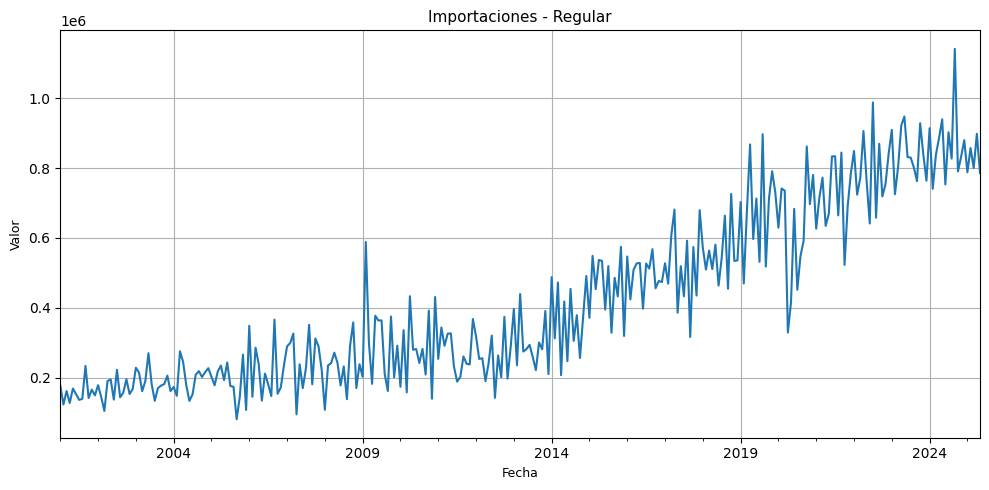

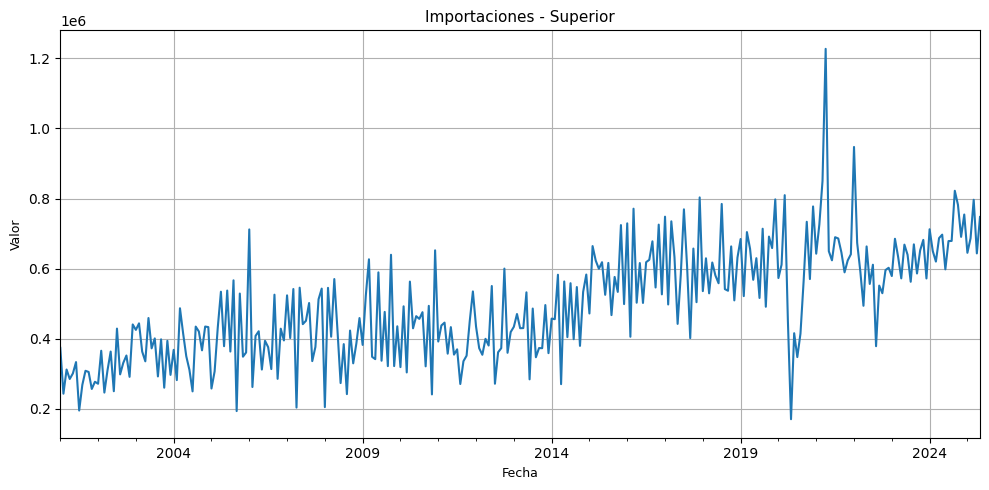

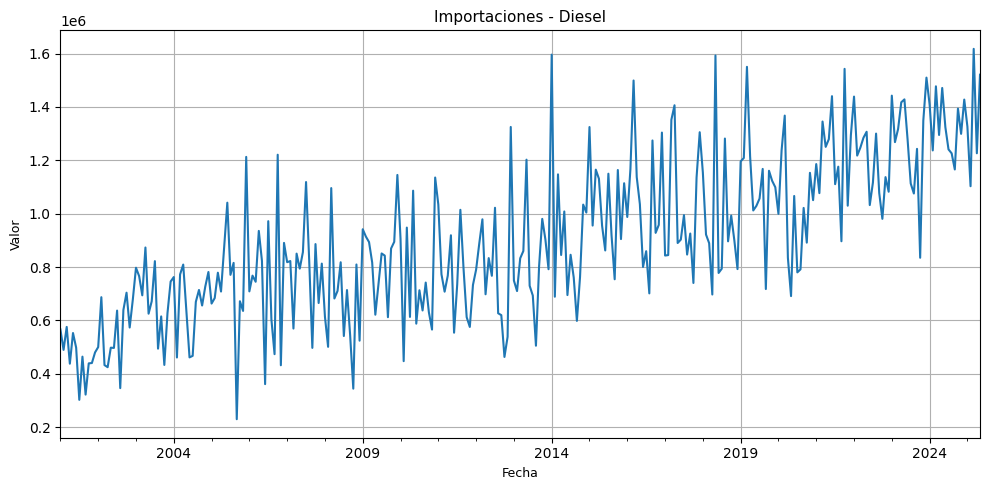

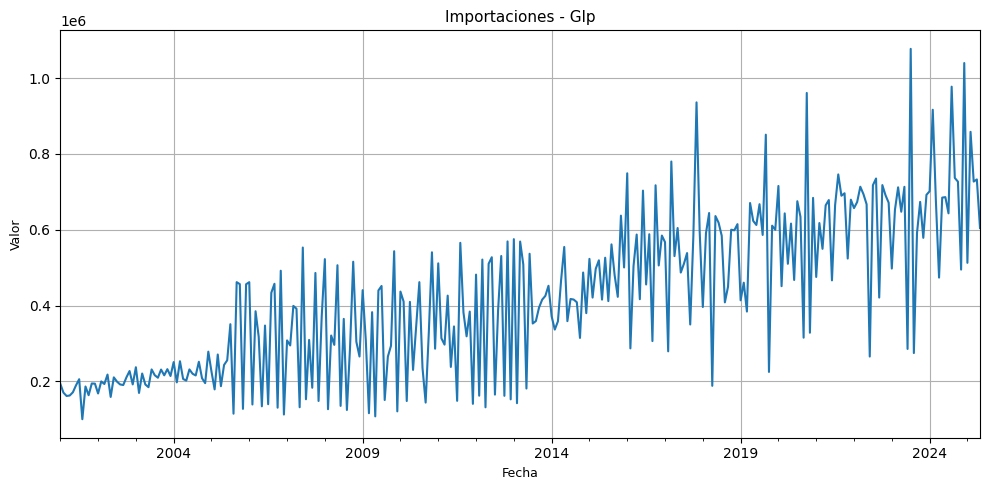

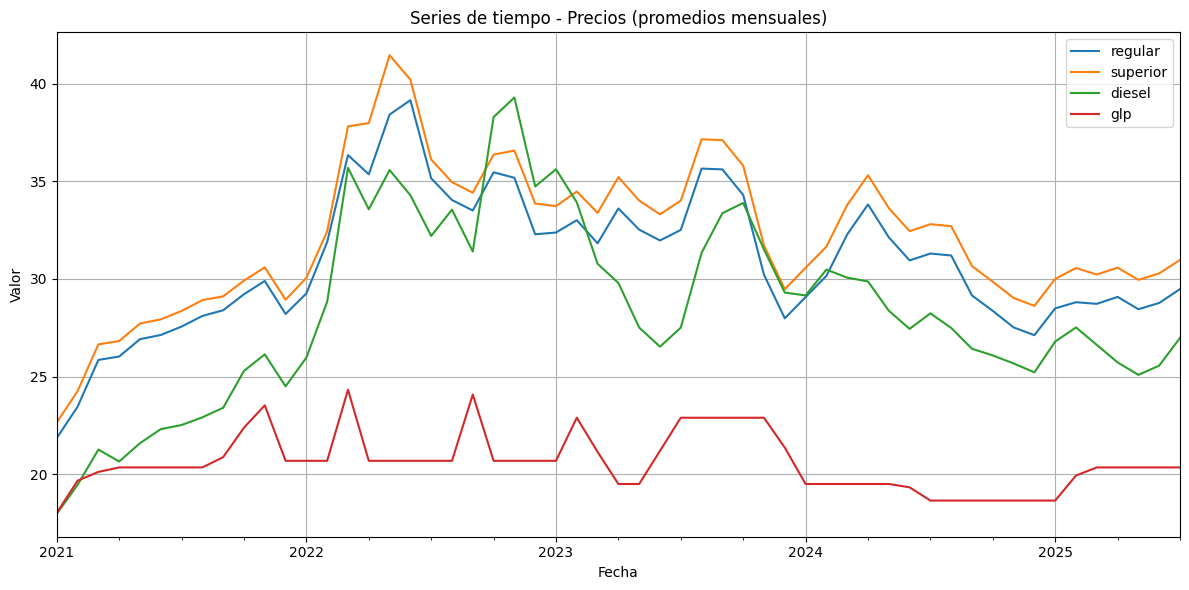

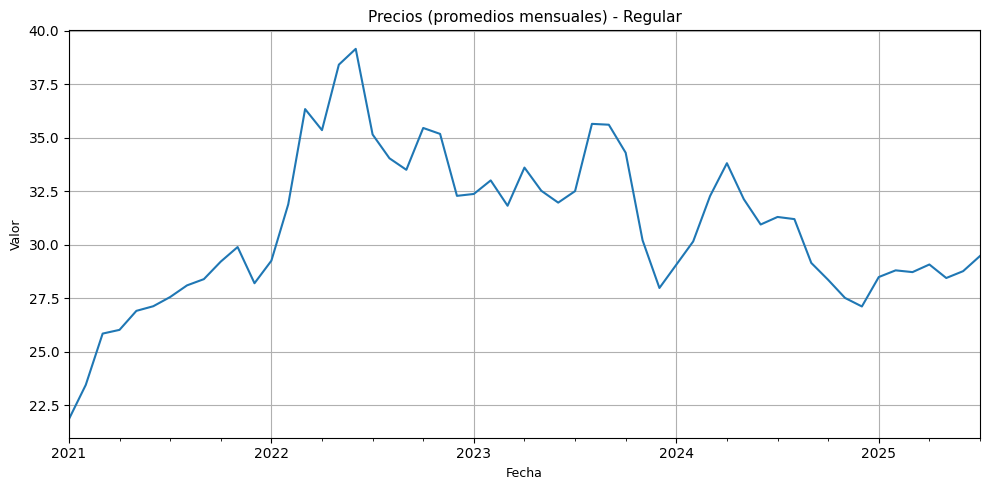

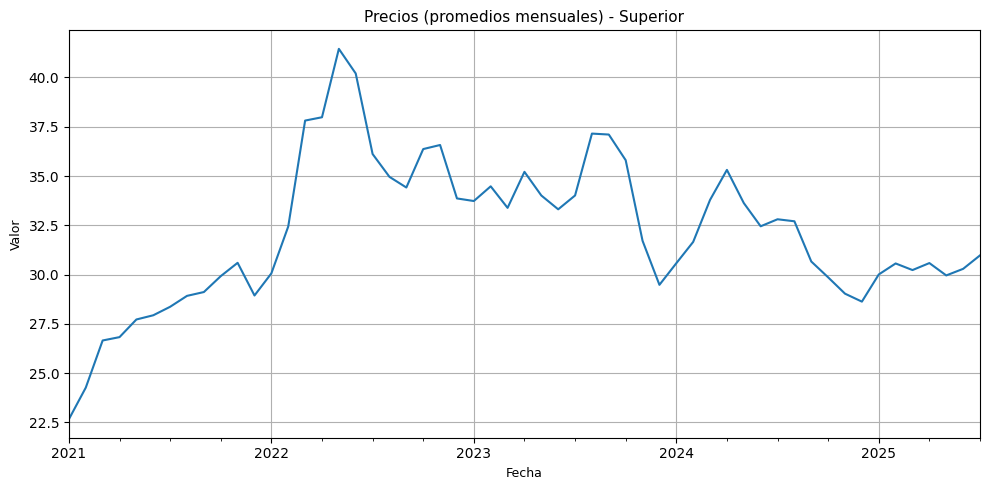

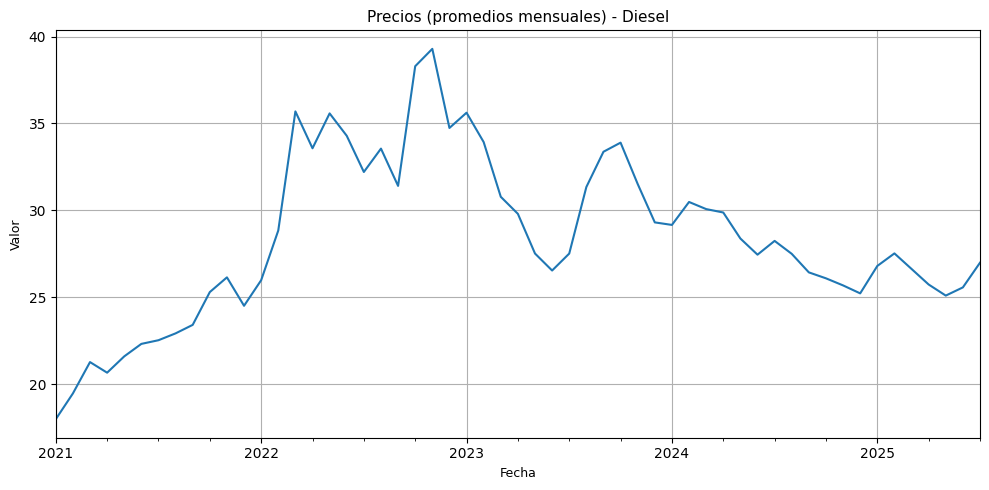

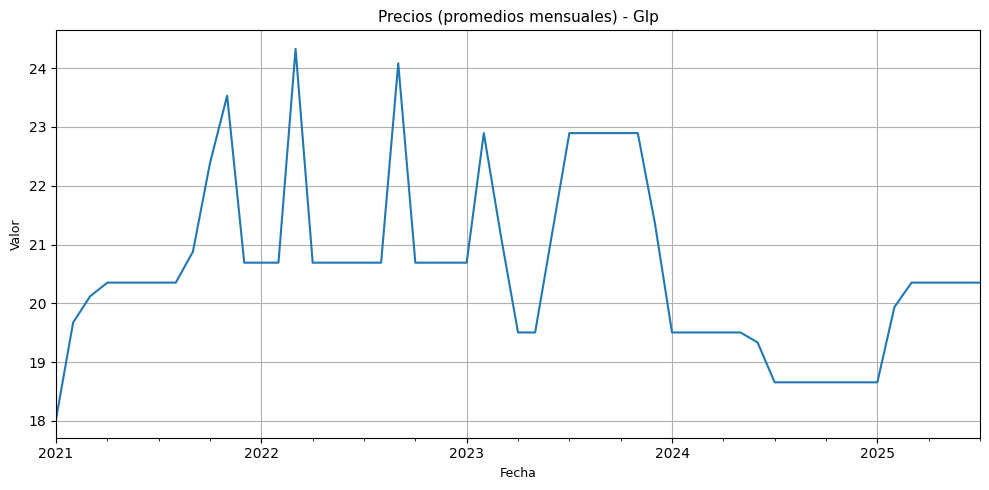

In [179]:
graphST(df_consumo, "Consumo", "consumo")
graphST(df_importaciones, "Importaciones", "importaciones")
graphST(
    df_precios.resample('ME').mean(),
    "Precios (promedios mensuales)",
    "precios"
)

In [ ]:
# Para más tarde xd

# from datetime import datetime

# import matplotlib.pyplot as plt

# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.arima.model import ARIMA

# import pmdarima as pm  # auto_arima

# from prophet import Prophet

# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from sklearn.neural_network import MLPRegressor  # NN simple o usar tensorflow dependerá por ahora el simple


# serie_precio_gasolina_regular      # Series de tiempo de precios mensual (Ciudad Capital)
# serie_import_diesel_total          # Serie mensual de importación total de diésel
# serie_consumo_gas_licuado          # Serie mensual de consumo de gas propano